In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.pyplot import *
import librosa
import pyaudio as pa
import wave
from scipy import signal
from scipy import fftpack

In [2]:
import struct
%matplotlib notebook

def decodePCM(rawData):
    npts=len(rawData)                     
    formatstr='%dh' % (npts/2)                
    int_data=struct.unpack(formatstr,rawData) 
    f_data = np.array([float(val) / pow(2, 15) for val in int_data])
    return f_data

def fft_bar_data(data_seq, bar_number):
    """
    suggest param range:
        bar_number: ~100
        half: 500~1000
     
    one solution: 0-padding freq to fixed length like 1000
    let's try 1000 first
    
    bar_size has granrantee the safety for this function
    """
    # to do: add robust safety check
    zero_padding = 1000 # by default
    data_freq = abs(fftpack.fftshift(fftpack.fft(data_seq, n=zero_padding))) # zero-padding to 2000
    bar_len = int((zero_padding/2) / bar_number) # THIS IS WTFFFF!!!!
    
    data_bar = np.zeros(bar_number)
    for i in range(bar_number):
        data_bar[i] = np.mean(data_freq[bar_len*i : bar_len*(i + 1)])
        
    return data_bar

In [3]:
def getRawData(filename):
    CHUNK = 1024
    
    wf = wave.open(filename, 'rb')

    p = pa.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    
    raw_data = []

    data = wf.readframes(CHUNK)

    while data != b'':
        stream.write(data)
        data = wf.readframes(CHUNK)
        raw_data.append(data)
        
    stream.stop_stream()
    stream.close()

    p.terminate()
    
    return raw_data

In [16]:
raw = getRawData("./static_dis.wav")

In [8]:
def dispStatic(raw_data_list, bar_no_idx):
    """
    raw_data is the list of bytes
    fixed-size spectrum display
    fixed-size bar number: 100?
    
    to gain safety we use bar_number_idx to select bar number
    """
    bar_size = [25, 50, 100, 200, 250]  # save this as class data later
    bar_number = bar_size[bar_no_idx]
    
    
    # probably dont need to init this if using circle chart
    # idx is one-time init
    freq_idx = np.r_[:bar_number]                                    
    freq_magn = np.zeros(bar_number)
    
#     fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     bars = plt.bar(freq_magn, freq_idx, alpha=0.75)
    fig,ax = plt.subplots(figsize=(5,5))
  
    for i in range(len(raw_data_list)):
        
        # update the data
        raw_data = raw_data_list[i]
        
        # for some werid reason we only need half of the freq
        data_bar = fft_bar_data(decodePCM(raw_data), bar_number) # see, if use class you don't need to write dumb code like this

        ax.cla()
        ax.bar(freq_idx, data_bar, width=0.3)

        fig.canvas.draw()
        fig.canvas.flush_events()

        
        


<IPython.core.display.Javascript object>


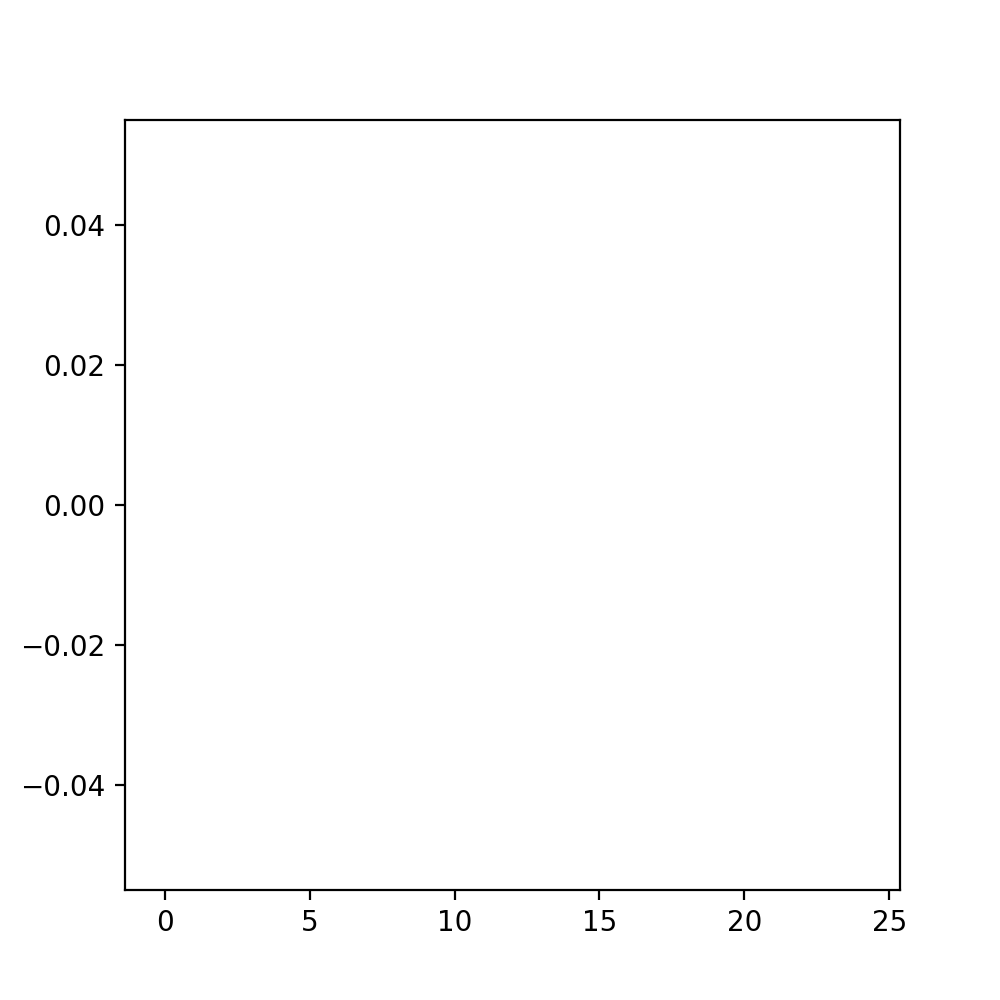

/Users/zhouhang/anaconda3/envs/song-recong/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [9]:
dispStatic(raw, 0)

In [21]:
import threading
import math
from queue import Queue
%matplotlib notebook

def consum(out_q, bar_no_idx):
    bar_size = [10, 50, 100, 200, 250]
    bar_number = bar_size[bar_no_idx]

    freq_idx = np.r_[:bar_number]                                    
    freq_magn = np.zeros(bar_number)
    
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_autoscaley_on(False)
#     ax.set_autoscale_on(False)
    ax.set_ylim([0, 20])
    while 1:
        raw_data = out_q.get(timeout = 0.3)
        
        data_bar = fft_bar_data(decodePCM(raw_data), bar_number)
        data_bar = data_bar
        ax.cla()
        ax.bar(freq_idx, data_bar, width=0.3)

        fig.canvas.draw()
        fig.canvas.flush_events()

        
        
def produce(in_q, filename):
    CHUNK = 1024
    
    wf = wave.open(filename, 'rb')

    p = pa.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    

    data = wf.readframes(CHUNK)

    while data != b'':
        stream.write(data)
        data = wf.readframes(CHUNK)
        in_q.put(data)
        
    stream.stop_stream()
    stream.close()

    p.terminate()
    


def main(filename, time = 5, rate = 22050, chunk = 512):
    
    q = Queue()
    
    t1 = threading.Thread(target=produce, args=(q, filename)) 
    t2 = threading.Thread(target=consum, args=(q, 0)) 
        
    t1.start()
    t2.start()
    
    t1.join()
    t2.join()

<IPython.core.display.Javascript object>


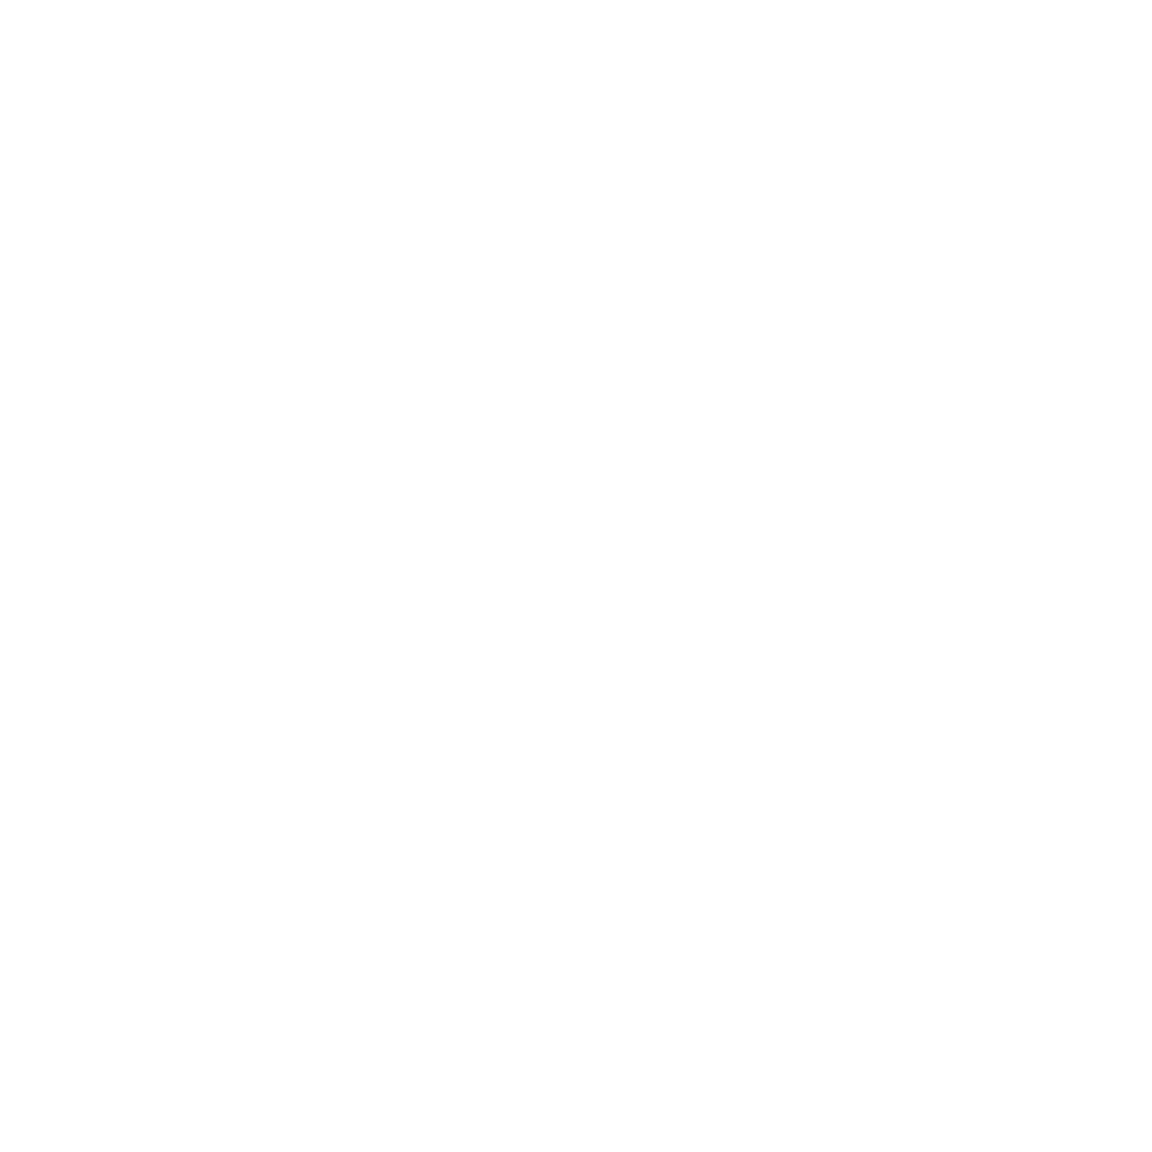

/Users/zhouhang/anaconda3/envs/song-recong/lib/python3.5/site-packages/scipy/fftpack/basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]
/Users/zhouhang/anaconda3/envs/song-recong/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
Exception in thread Thread-21:
Traceback (most recent call last):
  File "/Users/zhouhang/anaconda3/envs/song-recong/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/zhouhang/anaconda3/env

<IPython.core.display.Javascript object>


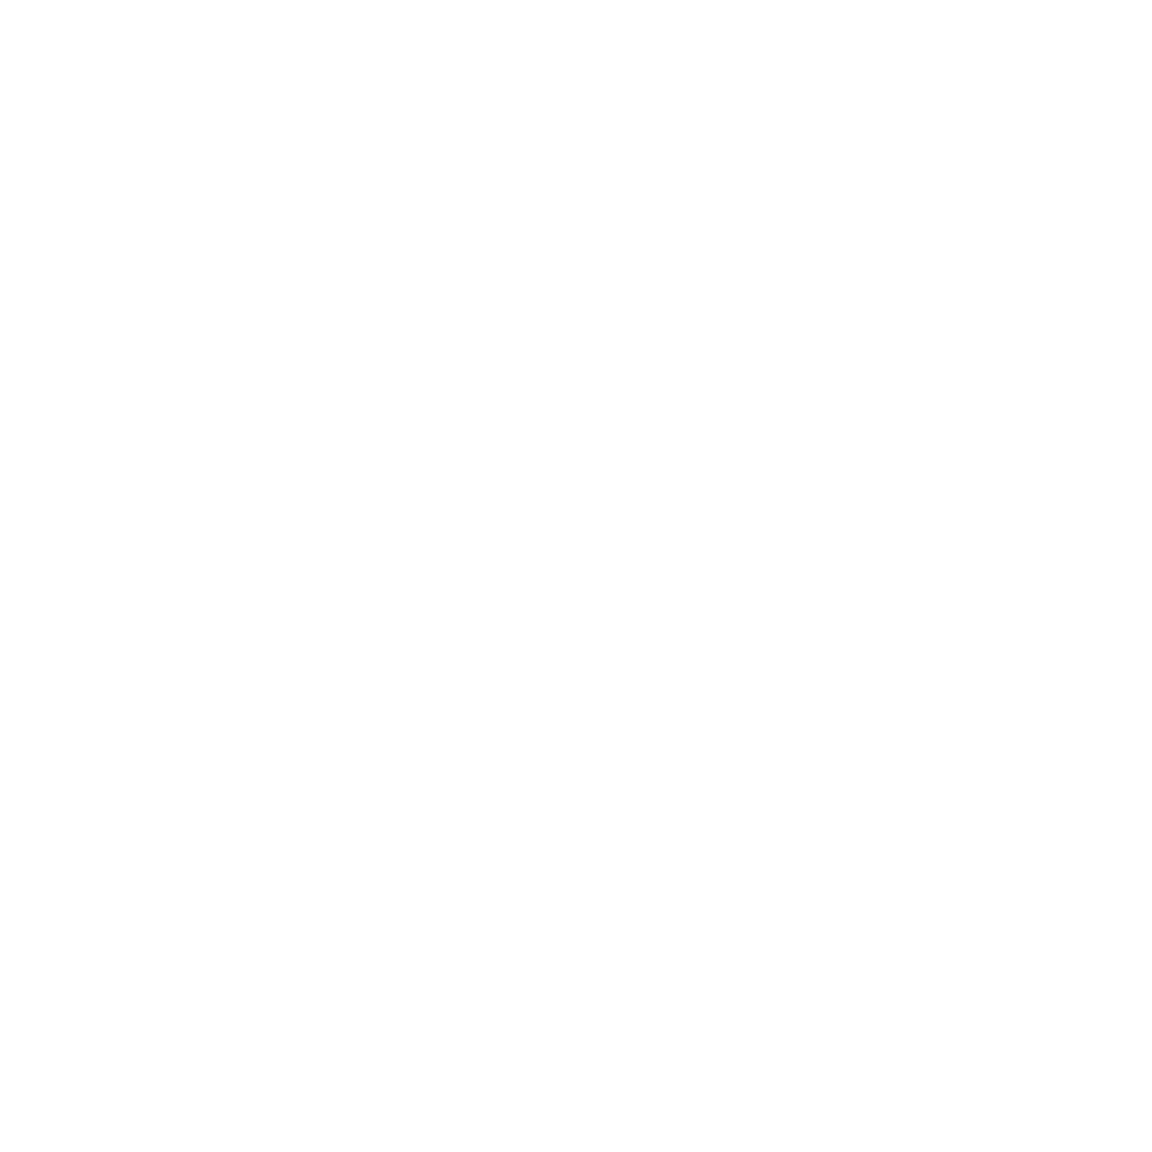

In [22]:
main("./test.wav")